# Data Analysis - 2D Square Lattice

In [1]:
import csv
import random

import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
import numpy as np

import seaborn as sns
import pandas as pd
import h5py
import os
from matplotlib.gridspec import GridSpec
import networkx as nx
import itertools
from matplotlib import colors


import colorsys
import community
#import visualization as vzl
# calculate Pearson's r correlation coeficient
from scipy.stats import spearmanr, pearsonr
from scipy.stats import linregress

import powerlaw
from scipy.optimize import curve_fit

### I/O

In [3]:
# Specify the file path
directory_path = "outputfolder/lattice2d_data"

simlations_out_list = []

# Iterate through the 'run' folders (run_1, run_2, ..., run_10)
for i in range(1, 51):
    run_folder = f"run_{i}"
    data_file = os.path.join(directory_path, run_folder, f"simulation_output_{i}.h5")
    with h5py.File(data_file, 'r') as hf:
        simlations_out_list.append(np.array(hf['simulation_data']))

/tmp/ipykernel_161/3650073634.py:11: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  simlations_out_list.append(np.array(hf['simulation_data']))


In [4]:
# Specify the path to your HDF5 file
file_path_loyalty = 'outputfolder/lattice2d_data/run_1/loyalty_output_1.h5'
# Open the HDF5 file in read mode
with h5py.File(file_path_loyalty, 'r') as hf:
    # Get the keys and sort them numerically
    sorted_keys = sorted(hf.keys(), key=lambda x: int(x.split('_')[-1]))
    dataset_loyalty = [] 
    # Now you can access datasets within the file
    for key in sorted_keys:
        dataset = hf[key]
        data_set = dataset[:]
        dataset_loyalty.append(data_set)

In [5]:
simulations_out = np.stack(simlations_out_list, axis=0)
del simlations_out_list
data = np.array(simulations_out)
del simulations_out

In [6]:
wealth_arr = data[:,:,10:]
wealth_year = wealth_arr[:,::33,:][:,1:,:]

In [7]:
print(wealth_arr.shape)
print(wealth_year.shape)

(50, 33001, 100)
(50, 1000, 100)


Wealth year, has information of how every year ends.

In [8]:
from matplotlib import ticker
from matplotlib.gridspec import GridSpec

## Individual dynamics

In [9]:
def wealth_plot(num):
    columns = ['decision']
    df = pd.DataFrame(data[num, 1:, 0], columns=columns)
    conflicts = df["decision"].fillna(0)
    
    # Create a grid layout with 3 rows and 1 column
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(3, 1, height_ratios=[1, 4, 12], hspace=0.3)

    # Plot barcode representation in the top subplot
    ax1 = plt.subplot(gs[0])
    ax1.imshow([conflicts], cmap='binary', aspect='auto', interpolation='none')
    ax1.set_yticks([])  
    ax1.set_xlim(0, 33000)
    ax1.tick_params(axis='x', which='both', bottom=False)
    # Add label "a)"
    ax1.text(-0.07, 0.5, "a)", transform=ax1.transAxes, size=15, weight='bold')

    # Plot line plot of total resources in the second subplot
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax2.plot(np.sum(wealth_arr[num, 1:, :], axis=1), color='black', linewidth=0.5, markeredgecolor='black')
    #ax2.set_ylabel('Global Resources ', fontsize = 20)  
    #ax2.grid(True)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))  # Adjust the limits if needed
    ax2.yaxis.set_major_formatter(formatter)
    # Add label "b)"
    ax2.text(-0.07, 0.5, "b)", transform=ax2.transAxes, size=15, weight='bold')

    # Plot heatmap in the third subplot
    ax3 = plt.subplot(gs[2], sharex=ax1)
    wealth_indv = wealth_arr[num, :, :]
    row_sums = np.sum(wealth_indv, axis=1)
    example = wealth_indv / row_sums[:, np.newaxis]

    im = ax3.imshow(example.T, cmap='Greys', interpolation='none', aspect='auto')
    ax3.set_ylabel('Actor', fontsize = 14)
    ax3.set_xlabel('Time', fontsize=14, labelpad=10)

    
    ax2.text(-0.07, 0.5, "c)", transform=ax3.transAxes, size=15, weight='bold')

    plt.show()


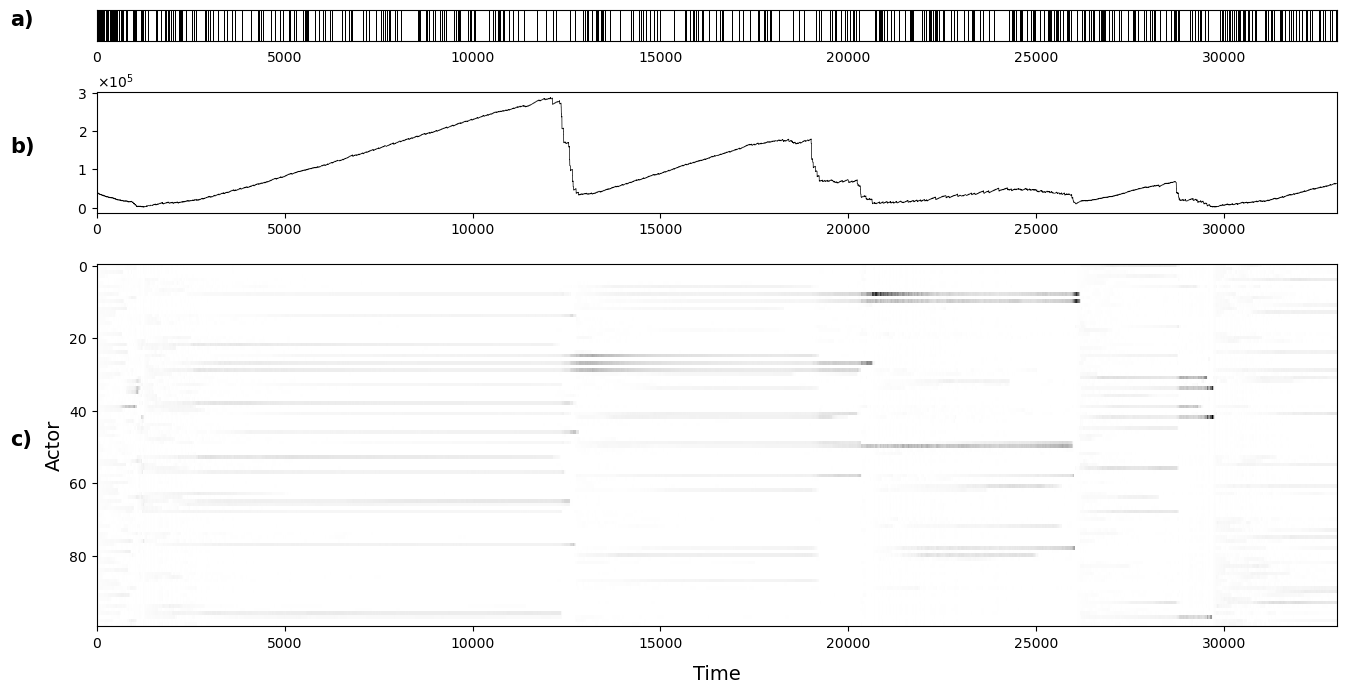

In [10]:
wealth_plot(19)

## Statistics individual

In [11]:
def gini(t):
    N = len(t)
    numerator = np.sum(np.abs(np.subtract.outer(t, t)))
    denominator = 2 * N * np.sum(t)
    index = numerator / denominator
    return index


In [12]:
def wealth_std(num):
    std_indx = np.zeros(wealth_year.shape[1]-1)
    for i in range(wealth_year.shape[1]-1):
        wealth_year_indv = wealth_year[num, :, :]
        row_sums = np.sum(wealth_year_indv, axis=1)
        example = wealth_year_indv / row_sums[:, np.newaxis]
        std_indx[i] = np.std(example[i, :])
    
    pop_test_sum_t = np.sum(wealth_year[num, :-1, :], axis=1)
    pop_test_sum_t_plus_1 = np.sum(wealth_year[num, 1:, :], axis=1)
    result = np.divide(pop_test_sum_t_plus_1, pop_test_sum_t, out=np.zeros_like(pop_test_sum_t), where=pop_test_sum_t != 0)
    # Calculate the interquartile range (IQR) of the result
    q75, q25 = np.percentile(result[100:], [75 ,25])
    iqr = q75 - q25
    # Set a threshold for outliers (e.g., 1.5 times the IQR)
    threshold = 2 * iqr
    below_threshold = (result < q25 - threshold)


    # Create a grid layout with 3 rows and 1 column
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(5, 1, height_ratios=[0.5, 1.5, 1.5, 2.2, 2.5], hspace=0.4)
    # Plot barcode representation in the top subplot
    ax1 = plt.subplot(gs[0])
    ax1.imshow([below_threshold[100:]], cmap='Greys', aspect='auto', interpolation='none')
    ax1.set_yticks([])
    ax1.tick_params(axis='x', which='both', bottom=False)
    ax1.set_xlim(0, 899)
    new_ticks = np.arange(100, 1000, 100)
    ax1.set_xticks(new_ticks - 100)  # Adjusting for the previous xlim
    ax1.set_xticklabels(new_ticks)
    ax1.text(-0.06, 0.5, "a)", transform=ax1.transAxes, size=15, weight='bold')

    # Plot line plot of np.sum(wealth_year) in the middle subplot
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax2.plot(result[100:], color='blue', linewidth=0.5, markeredgecolor='black')
    #ax2.set_ylabel('W(t+1)/W(t)')
    ax2.set_xlim(0, 899)
    ax2.grid(True)
    ax2.text(-0.06, 0.5, "b)", transform=ax2.transAxes, size=15, weight='bold')
    
    #ax3 = plt.subplot(gs[2], sharex = ax1)
    #ax3.plot(std_indx[100:], color='green', linewidth=0.5, markeredgecolor='black')
    #ax3.set_ylabel('Standard Deviation')
    #ax3.set_xlim(0, 899)
    #ax3.grid(True)
    #ax3.text(-0.09, 0.5, "c)", transform=ax3.transAxes, size=15, weight='bold')
    
    test = wealth_year[num,:,:]
    gini_indx = np.zeros(test.shape[0])
    for i in range(test.shape[0]):
        gini_indx[i] = gini(test[i,:])
    ax3 = plt.subplot(gs[2], sharex = ax1)
    ax3.plot(gini_indx[100:], color='red', linewidth=0.5, markeredgecolor='black')
    #ax4.set_ylabel('Gini Index')
    ax3.set_xlim(0, 899)
    ax3.grid(True)
    ax3.text(-0.06, 0.5, "c)", transform=ax3.transAxes, size=15, weight='bold')
    
    # Plot line plot of np.sum(wealth_year) in the bottom subplot
    ax4 = plt.subplot(gs[3], sharex=ax1)
    ax4.plot(np.sum(wealth_year[num, 1:, :], axis=1)[100:], color='black', linewidth=1, markeredgecolor='black')
    ax4.set_xlabel('Time (Year)', fontsize = 14)
    #ax4.set_ylabel('Global Resources')
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))  # Adjust the limits if needed
    ax4.yaxis.set_major_formatter(formatter)
    ax4.set_xlim(0, 899)
    ax4.grid(True)
    ax4.text(-0.06, 0.5, "d)", transform=ax4.transAxes, size=15, weight='bold')

    plt.show()

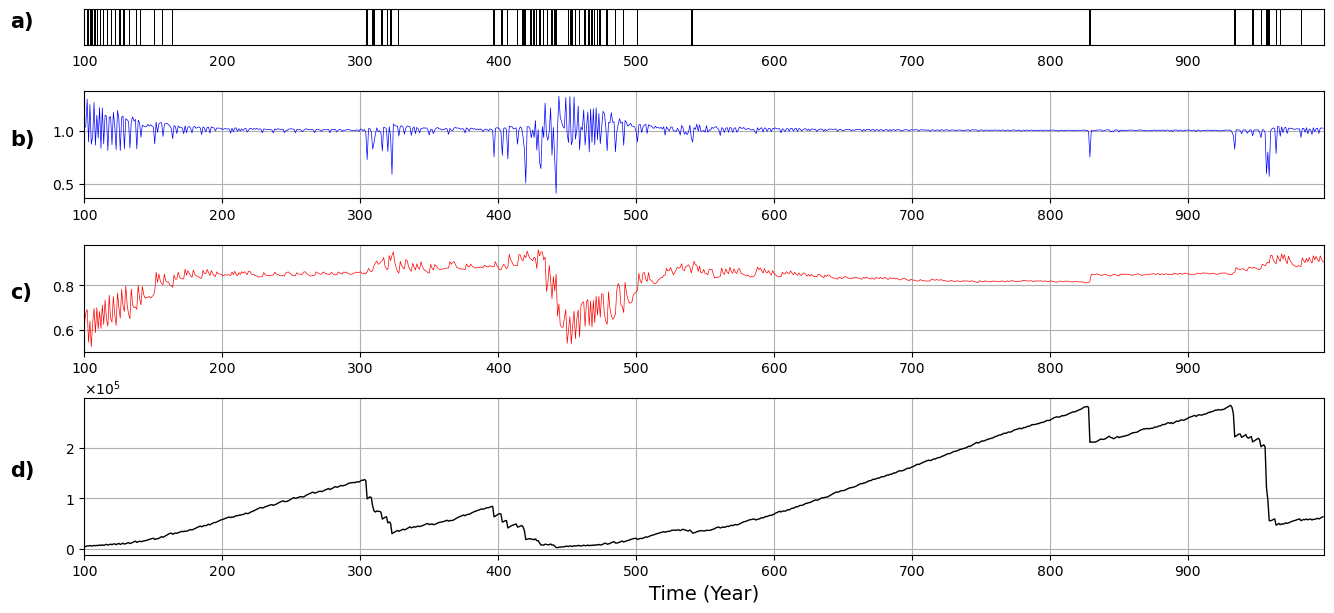

In [13]:
wealth_std(0)

## Conflict Sizes

In [14]:
conflict_size = []
for i in range(data.shape[0]):
    columns = ['decision', 'attacker', 'target', 'loyalty', 'Tau', 'alpha', 'Wealth_def', 'Wealth_att','path_len',"change"]
    df = pd.DataFrame(data[i,33*500:,:10], columns=columns)
    conflict_df = df[df['decision'] == 1].reset_index(drop=True)
    size_war = conflict_df[['alpha', 'Tau']].sum(axis=1)
    b = size_war.values.tolist()
    conflict_size.extend(b)

In [15]:
# Fit a power-law to the entire dataset
fit_size = powerlaw.Fit(conflict_size, xmax = 92 , discrete=True)

Calculating best minimal value for power law fit


/home/brandm/anaconda3/envs/py39/lib/python3.9/site-packages/powerlaw.py:1195: RuntimeWarning: divide by zero encountered in scalar divide
  C = 1.0/C
/home/brandm/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


/home/brandm/anaconda3/envs/py39/lib/python3.9/site-packages/powerlaw.py:840: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C


In [16]:
xmin = fit_size.find_xmin()
print("xmin:", xmin)

xmin: 7.0ress: 98%


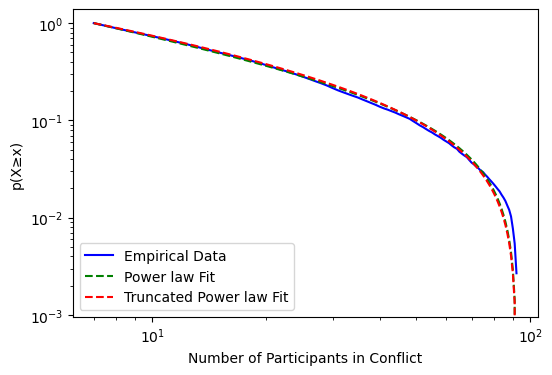

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))

#fit_size.plot_pdf(color='b', label=r"Empirical Data")
#fit_size.power_law.plot_pdf(color='r', linestyle='--', ax=ax, label=r"Power law Fit")
#fit_size.lognormal.plot_pdf(color='g', linestyle='--', ax=ax, label=r"Lognormal Fit")
#fit_size.exponential.plot_pdf(color='k', linestyle='--', ax=ax, label=r"Exponential Fit")
#fit_size.truncated_power_law.plot_pdf(color='c', linestyle='--', ax=ax, label=r"Truncated Fit")

fit_size.plot_ccdf(color='b', label=r"Empirical Data")
fit_size.power_law.plot_ccdf(color='g', linestyle='--', ax=ax, label=r"Power law Fit")
fit_size.truncated_power_law.plot_ccdf(color='r', linestyle='--', ax=ax, label=r"Truncated Power law Fit")
#fit_size.lognormal.plot_ccdf(color='g', linestyle='--', ax=ax, label=r"Lognormal Fit")
#fit_size.exponential.plot_ccdf(color='k', linestyle='--', ax=ax, label=r"Exponential Fit")



plt.xlabel('Number of Participants in Conflict')
plt.ylabel(u'p(X≥x)')
plt.legend( loc=3)

plt.show()


In [18]:
print(fit_size.distribution_compare('power_law', 'lognormal', normalized_ratio=True))
print(fit_size.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True))
print(fit_size.distribution_compare('lognormal', 'truncated_power_law', normalized_ratio=True))

(-4.560689378040849, 5.098595588459948e-06)
(-13.61865660261385, 0.0)
(-20.326530036632217, 7.491677633893109e-92)


Assuming nested distributions


In [19]:
print(fit_size.truncated_power_law.parameter1)  # This will print the alpha parameter
print(fit_size.truncated_power_law.parameter2)  # This will print the lambda parameter
# Print the exponents of the power-law fits
print("Fit Exponent:", fit_size.power_law.alpha)


1.5706587806063221
0.005026835454965562
Fit Exponent: 1.6991044044967647


# Violent conflicts

In [21]:
dt = []
for i in range(50): 
    pop_test_sum_t = np.sum(wealth_arr[i, :-1, :], axis=1)
    pop_test_sum_t_plus_1 = np.sum(wealth_arr[i, 1:, :], axis=1)
    result = np.divide(pop_test_sum_t_plus_1, pop_test_sum_t, out=np.zeros_like(pop_test_sum_t), where=pop_test_sum_t != 0)
    # Calculate the interquartile range (IQR) of the result
    q75, q25 = np.percentile(result[:33*100], [75 ,25])
    iqr = q75 - q25

    # Set a threshold for outliers (e.g., 1.5 times the IQR)
    threshold = 1.5* iqr
    below_threshold = (result[:33*100] < q25 - threshold)

    true_indices = np.where(below_threshold)[0]
    intervals = np.diff(true_indices) - 1
    nonzero_intervals = intervals[intervals != 0] #exclude consecutive conflicts
    dt.extend(nonzero_intervals)

In [22]:
# Fit a power-law to the entire dataset
fit_dt = powerlaw.Fit(dt, xmin = 1, xmax = None , discrete=True)

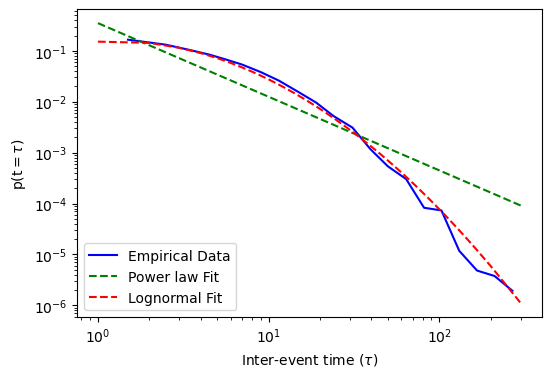

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))

fit_dt.plot_pdf(color='b', label=r"Empirical Data")
fit_dt.power_law.plot_pdf(color='g', linestyle='--', ax=ax, label=r"Power law Fit")
#fit_dt.truncated_power_law.plot_pdf(color='r', linestyle='--', ax=ax, label=r"Truncated Power law Fit")
fit_dt.lognormal.plot_pdf(color='r', linestyle='--', ax=ax, label=r"Lognormal Fit")
#fit_dt.stretched_exponential.plot_pdf(color='c', linestyle='--', ax=ax, label=r"Exponential Fit")


# fit_dt.plot_ccdf(color='b', label=r"Empirical Data")
# fit_dt.power_law.plot_ccdf(color='g', linestyle='--', ax=ax, label=r"Power law Fit")
# fit_dt.truncated_power_law.plot_ccdf(color='c', linestyle='--', ax=ax, label=r"Truncated Power law Fit")
# fit_dt.lognormal.plot_ccdf(color='r', linestyle='--', ax=ax, label=r"Lognormal Fit")
# fit_dt.exponential.plot_ccdf(color='k', linestyle='--', ax=ax, label=r"Exponential Fit")

plt.xlabel(r'Inter-event time ($\tau$)')
plt.ylabel(r'p(t$=\tau$)')
plt.legend( loc=3)

plt.show()

In [24]:
print(fit_dt.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True))
print(fit_dt.distribution_compare('lognormal', 'truncated_power_law', normalized_ratio=True))
print(fit_dt.distribution_compare('lognormal', 'power_law', normalized_ratio=True))
print(fit_dt.distribution_compare('lognormal', 'stretched_exponential', normalized_ratio=True))

Assuming nested distributions


(11.548711364047314, 0.0)
(41.21069321330001, 0.0)
(62.11127385156078, 0.0)
(1.4069636502241678, 0.1594381677532909)


In [25]:
print(fit_dt.lognormal.mu)  # This will print the alpha parameter
print(fit_dt.lognormal.parameter2)  # This will print the lambda parameter

1.4601314174983488
1.1346784211152463


In [29]:
# Fit a power-law to the entire dataset
fit_dt_hi = powerlaw.Fit(dt, xmax = None , discrete=True)

Calculating best minimal value for power law fit


In [30]:
xmin = fit_dt_hi.find_xmin()
print("xmin:", xmin)

xmin: 27.0


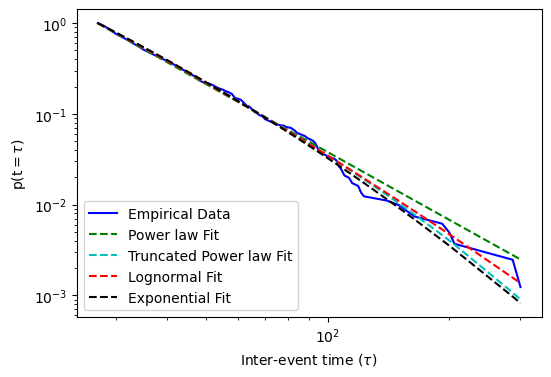

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))

# fit_dt_hi.plot_pdf(color='b', label=r"Empirical Data")
# fit_dt_hi.power_law.plot_pdf(color='y', linestyle='--', ax=ax, label=r"Power law Fit")
# fit_dt_hi.truncated_power_law.plot_pdf(color='r', linestyle='--', ax=ax, label=r"Truncated Power law Fit")
# fit_dt_hi.lognormal.plot_pdf(color='g', linestyle='--', ax=ax, label=r"Lognormal Fit")
# #fit_dt_hi.exponential.plot_pdf(color='c', linestyle='--', ax=ax, label=r"Exponential Fit")


fit_dt_hi.plot_ccdf(color='b', label=r"Empirical Data")
fit_dt_hi.power_law.plot_ccdf(color='g', linestyle='--', ax=ax, label=r"Power law Fit")
fit_dt_hi.truncated_power_law.plot_ccdf(color='c', linestyle='--', ax=ax, label=r"Truncated Power law Fit")
fit_dt_hi.lognormal.plot_ccdf(color='r', linestyle='--', ax=ax, label=r"Lognormal Fit")
#fit_dt_hi.exponential.plot_ccdf(color='k', linestyle='--', ax=ax, label=r"Exponential Fit")
fit_dt_hi.stretched_exponential.plot_ccdf(color='k', linestyle='--', ax=ax, label=r"Exponential Fit")



plt.xlabel(r'Inter-event time ($\tau$)')
plt.ylabel(r'p(t$=\tau$)')
plt.legend( loc=3)

plt.show()

In [32]:
print(fit_dt_hi.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=False))
print(fit_dt_hi.distribution_compare('lognormal', 'truncated_power_law', normalized_ratio=True))
print(fit_dt_hi.distribution_compare('lognormal', 'power_law', normalized_ratio=True))
print(fit_dt_hi.distribution_compare('stretched_exponential', 'power_law', normalized_ratio=True))


(-1.2998549019577395, 0.10688328431364835)
(-1.2938892951531866, 0.19570366263602879)
(0.7934634853986331, 0.4275078353984082)
(0.3173823077674378, 0.7509535301616354)


Assuming nested distributions


In [33]:
print(fit_dt_hi.truncated_power_law.parameter1)  # This will print the alpha parameter
print(fit_dt_hi.truncated_power_law.parameter2)  # This will print the lambda parameter
print(fit_dt_hi.lognormal.parameter1)  # This will print the alpha parameter
print(fit_dt_hi.lognormal.parameter2)  # This will print the lambda parameter
# Print the exponents of the power-law fits
print("Fit Exponent:", fit_dt_hi.power_law.alpha)

3.1630208204622954
0.004717755215917994
-3.4307669048032707
1.7387011860117783
Fit Exponent: 3.473075256617898


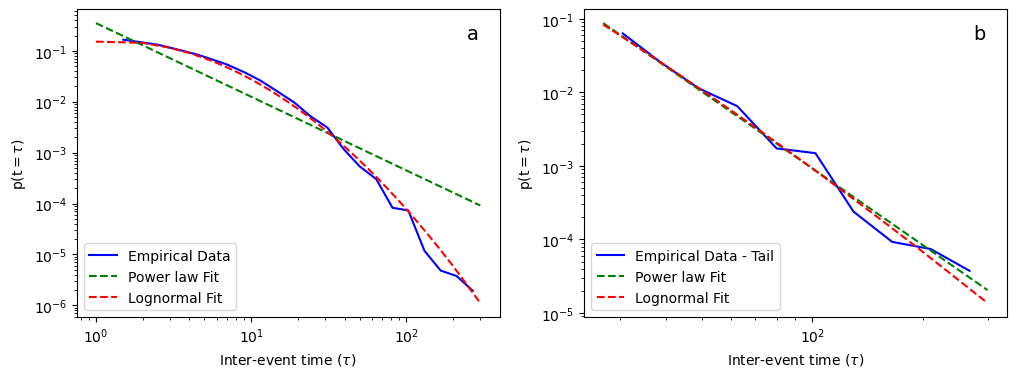

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot for low-frequency conflicts
fit_dt.plot_pdf(color='b', label=r"Empirical Data", ax=ax1)
fit_dt.power_law.plot_pdf(color='g', linestyle='--', ax=ax1, label=r"Power law Fit")
fit_dt.lognormal.plot_pdf(color='r', linestyle='--', ax=ax1, label=r"Lognormal Fit")
#fit_dt.exponential.plot_pdf(color='c', linestyle='--', ax=ax1, label=r"Exponential Fit")

ax1.set_xlabel(r'Inter-event time ($\tau$)')
ax1.set_ylabel(r'p(t$=\tau$)')
ax1.legend(loc=3)
ax1.text(0.95, 0.95, 'a', transform=ax1.transAxes, fontsize=14, va='top', ha='right')

# Plot for high-frequency conflicts
fit_dt_hi.plot_pdf(color='b', label=r"Empirical Data - Tail", ax=ax2)
fit_dt_hi.power_law.plot_pdf(color='g', linestyle='--', ax=ax2, label=r"Power law Fit")
#fit_dt_hi.truncated_power_law.plot_pdf(color='r', linestyle='--', ax=ax2, label=r"Truncated Power law Fit")
fit_dt_hi.lognormal.plot_pdf(color='r', linestyle='--', ax=ax2, label=r"Lognormal Fit")

ax2.set_xlabel(r'Inter-event time ($\tau$)')
ax2.set_ylabel(r'p(t$=\tau$)')
ax2.legend(loc=3)
ax2.text(0.95, 0.95, 'b', transform=ax2.transAxes, fontsize=14, va='top', ha='right')

plt.show()


## Inequality: Gini index

In [35]:
gini_values = np.zeros(50)
for i in range(50):
    gini_indx = np.zeros(1000-500)
    for j in range(1000-500):
        gini_indx[j] = gini(wealth_year[i, j+500, :])
    gini_values[i] = gini_indx.mean()
    

### Wealth Distribution

In [37]:
tot_wealth_actor = np.mean(wealth_year[:,500:,:], axis=1)

In [38]:
tot_wealth_actor.shape

(50, 100)

In [39]:
wealth_flat_actors = np.ravel(tot_wealth_actor)
#wealth_flat_actors_mean = np.ravel(tot_wealth_actor_mean)

In [40]:
# Calculate the PDF using numpy.histogram
hist, bin_edges = np.histogram(wealth_flat_actors, bins='auto', density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
pdf = hist / np.sum(hist)

# Calculate the CDF and CCDF
cdf = np.cumsum(hist) / np.sum(hist)
ccdf = 1 - cdf


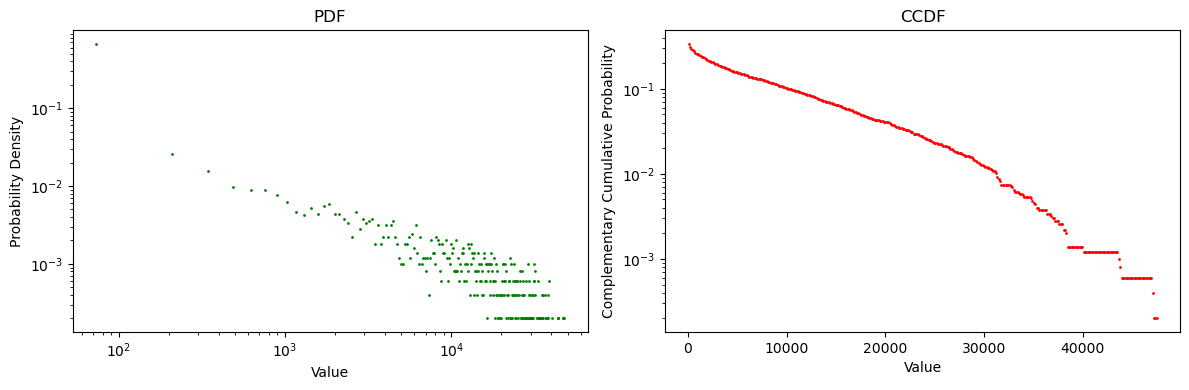

In [41]:
# Plot the PDF
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(bin_centers, pdf, color='green', marker='o', linestyle=' ', markersize=1)
plt.xscale('log')  # Set x-axis to log scale
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('PDF')

# Plot the CDF
plt.subplot(1, 2, 2)
plt.plot(bin_centers[:-1], ccdf[:-1], color='red', marker='o', linestyle=' ', markersize=1)
#plt.xscale('log')
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Complementary Cumulative Probability')
plt.title('CCDF')

plt.tight_layout()
plt.show()


# Network Visualization and patterns

## Coalitions on the Grid

In [42]:
def generate_consecutive_colors(num_colors):
    colors = []
    for i in range(num_colors):
        hue = i / num_colors  # Generate hue values from 0 to 1
        saturation = 0.9  # You can adjust saturation and value to get different shades of colors
        value = 0.9
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append(rgb)
    return colors

cluster_colors = generate_consecutive_colors(100)
random.shuffle(cluster_colors)

In [43]:
def groups(test_mtx):
    G = nx.Graph()
    G.add_nodes_from(range(len(test_mtx)))
    for i in range(len(test_mtx)):
        for j in range(len(test_mtx)):
            if i != j and test_mtx[i, j] >= 5:  # Exclude self-edges
                G.add_edge(i, j, weight=test_mtx[i, j])

    partition = community.best_partition(G)
    matrix = np.zeros((10, 10))
    # Populate the matrix based on the partition dictionary
    for node, group in partition.items():
        row = (node ) // 10  # Adjust node index to start from 0
        col = (node) % 10
        matrix[row, col] = group
    return matrix

In [44]:
#positions_to_extract = [10, 50, 100, 250, 500, 1000]
positions_to_extract = [ 300-2, 600-2, 1000-2]
loyal_val_0 = []
# Extract values at specific positions from each matrix
for i in positions_to_extract:
    loyal_val_0.append(dataset_loyalty[i])

In [45]:
groups_list = [np.zeros((10,10))]
for i in loyal_val_0:
    groups_list.append(groups(i))

In [46]:
groups_list[-1] =  1- groups_list[-1]

/tmp/ipykernel_161/2122747292.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma')  # You can choose a different colormap here


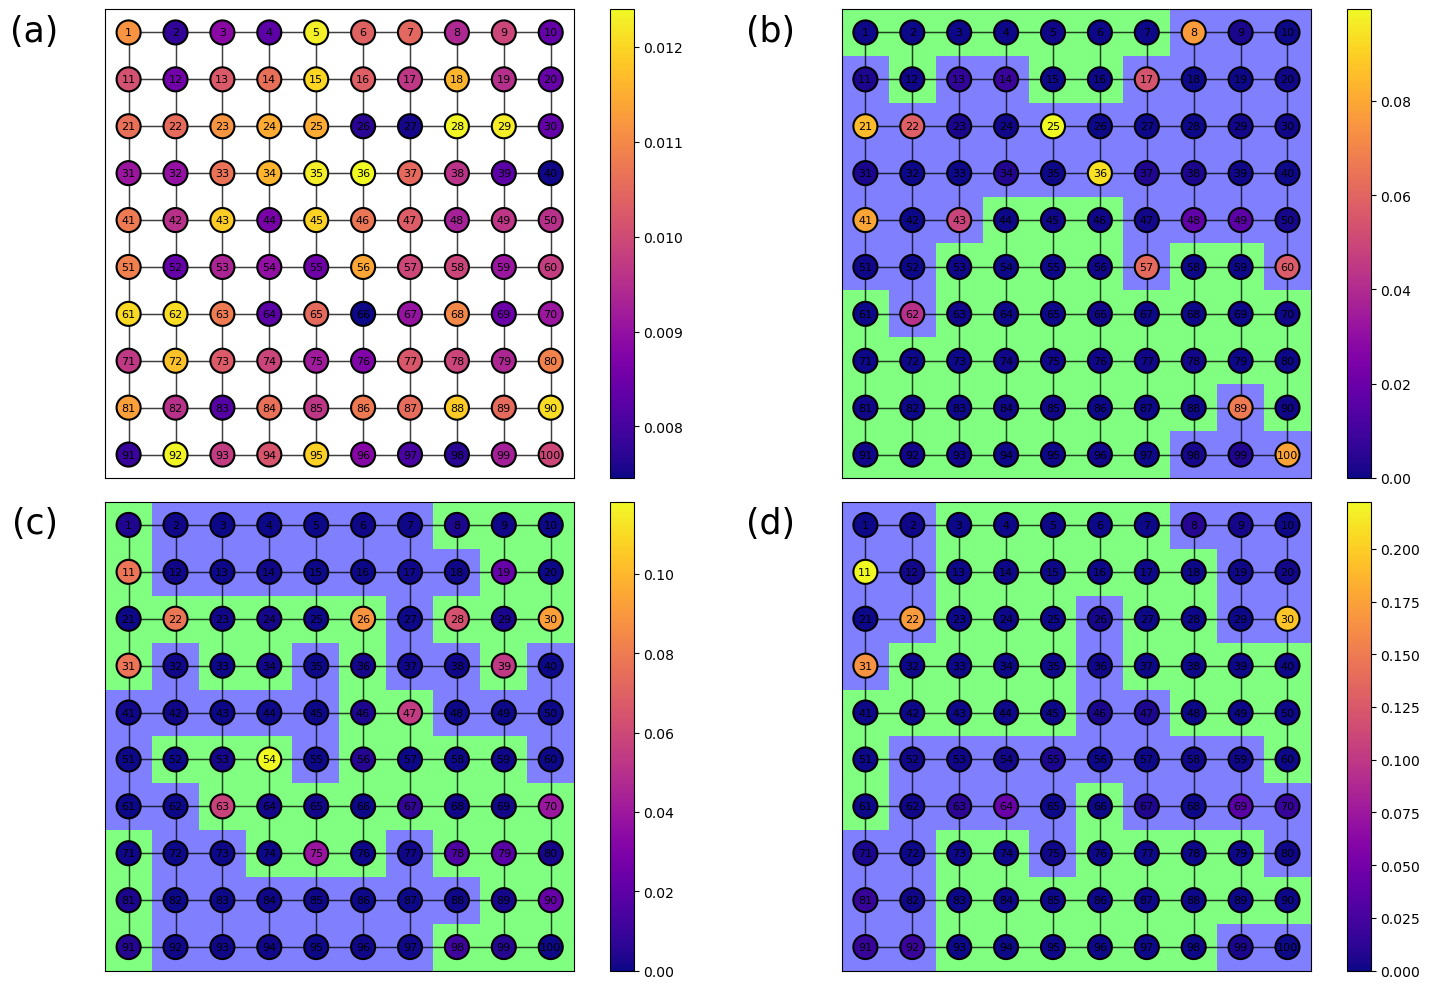

In [47]:
# You can adjust 'i_values' as needed
i_values = [0, 200-2, 600-2, 1000-2]

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Generate the 2D square lattice with periodic boundaries
G = nx.grid_2d_graph(10, 10, periodic=True)
# Rename the labels of nodes from 1 to 100
mapping = {(i, j): i * 10 + j + 1 for i, j in G.nodes()}
G = nx.relabel_nodes(G, mapping)
pos = {node: ((node-1) % 10, -node // 10) for node in G.nodes()}

# Loop through i_values and plot the heatmaps
for i, ax in enumerate(axes.flat):
    if i < len(i_values):
        if i ==0:
            values_wealth = wealth_arr[0,0,:]
            values_wealth = values_wealth/np.sum(values_wealth)
        else:    
            values_wealth = wealth_year[0, i_values[i], :]  # population, year, wealth
            values_wealth = values_wealth/np.sum(values_wealth)

        # Draw nodes with custom attributes based on wealth_year
        node_colors = [values_wealth[node - 1] for node in G.nodes()]
        cmap = plt.cm.get_cmap('plasma')  # You can choose a different colormap here

        # Calculate color limits based on the minimum and maximum values of values_wealth
        vmin, vmax = min(values_wealth), max(values_wealth)

        nx.draw_networkx_nodes(G, pos, node_size=300, node_shape="o", node_color=node_colors, cmap=cmap, ax=ax, edgecolors='black', linewidths=1.5)
        nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', ax=ax)

        # Draw edges
        nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

        # Add a colorbar to show wealth values for each subplot
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        #cbar.set_label('Wealth', fontsize=20)
        #if i>0:
        # Create a colored matrix (assuming wealth_year is a 3D array)
        matrix = groups_list[i]
        if i ==0:
            # Display the matrix as an image
            ax.imshow(matrix, cmap='gray_r', extent=[-0.5, 9.5, -10.5, -0.5], alpha=0.5, origin='upper')   
        else:
            if i==1:
                 matrix = np.logical_not(matrix).astype(int)
            # Display the matrix as an image
            ax.imshow(matrix, cmap='brg', extent=[-0.5, 9.5, -10.5, -0.5], alpha=0.5, origin='upper')
        # Add labels in the corner
        ax.text(-0.1, 0.99, f'({chr(ord("a") + i)})', transform=ax.transAxes, fontsize=25,
                verticalalignment='top', horizontalalignment='right')
plt.tight_layout()
plt.show()


## Commitments Network

In [48]:
loyalty = np.stack(dataset_loyalty, axis=0)

IndexError: list index out of range

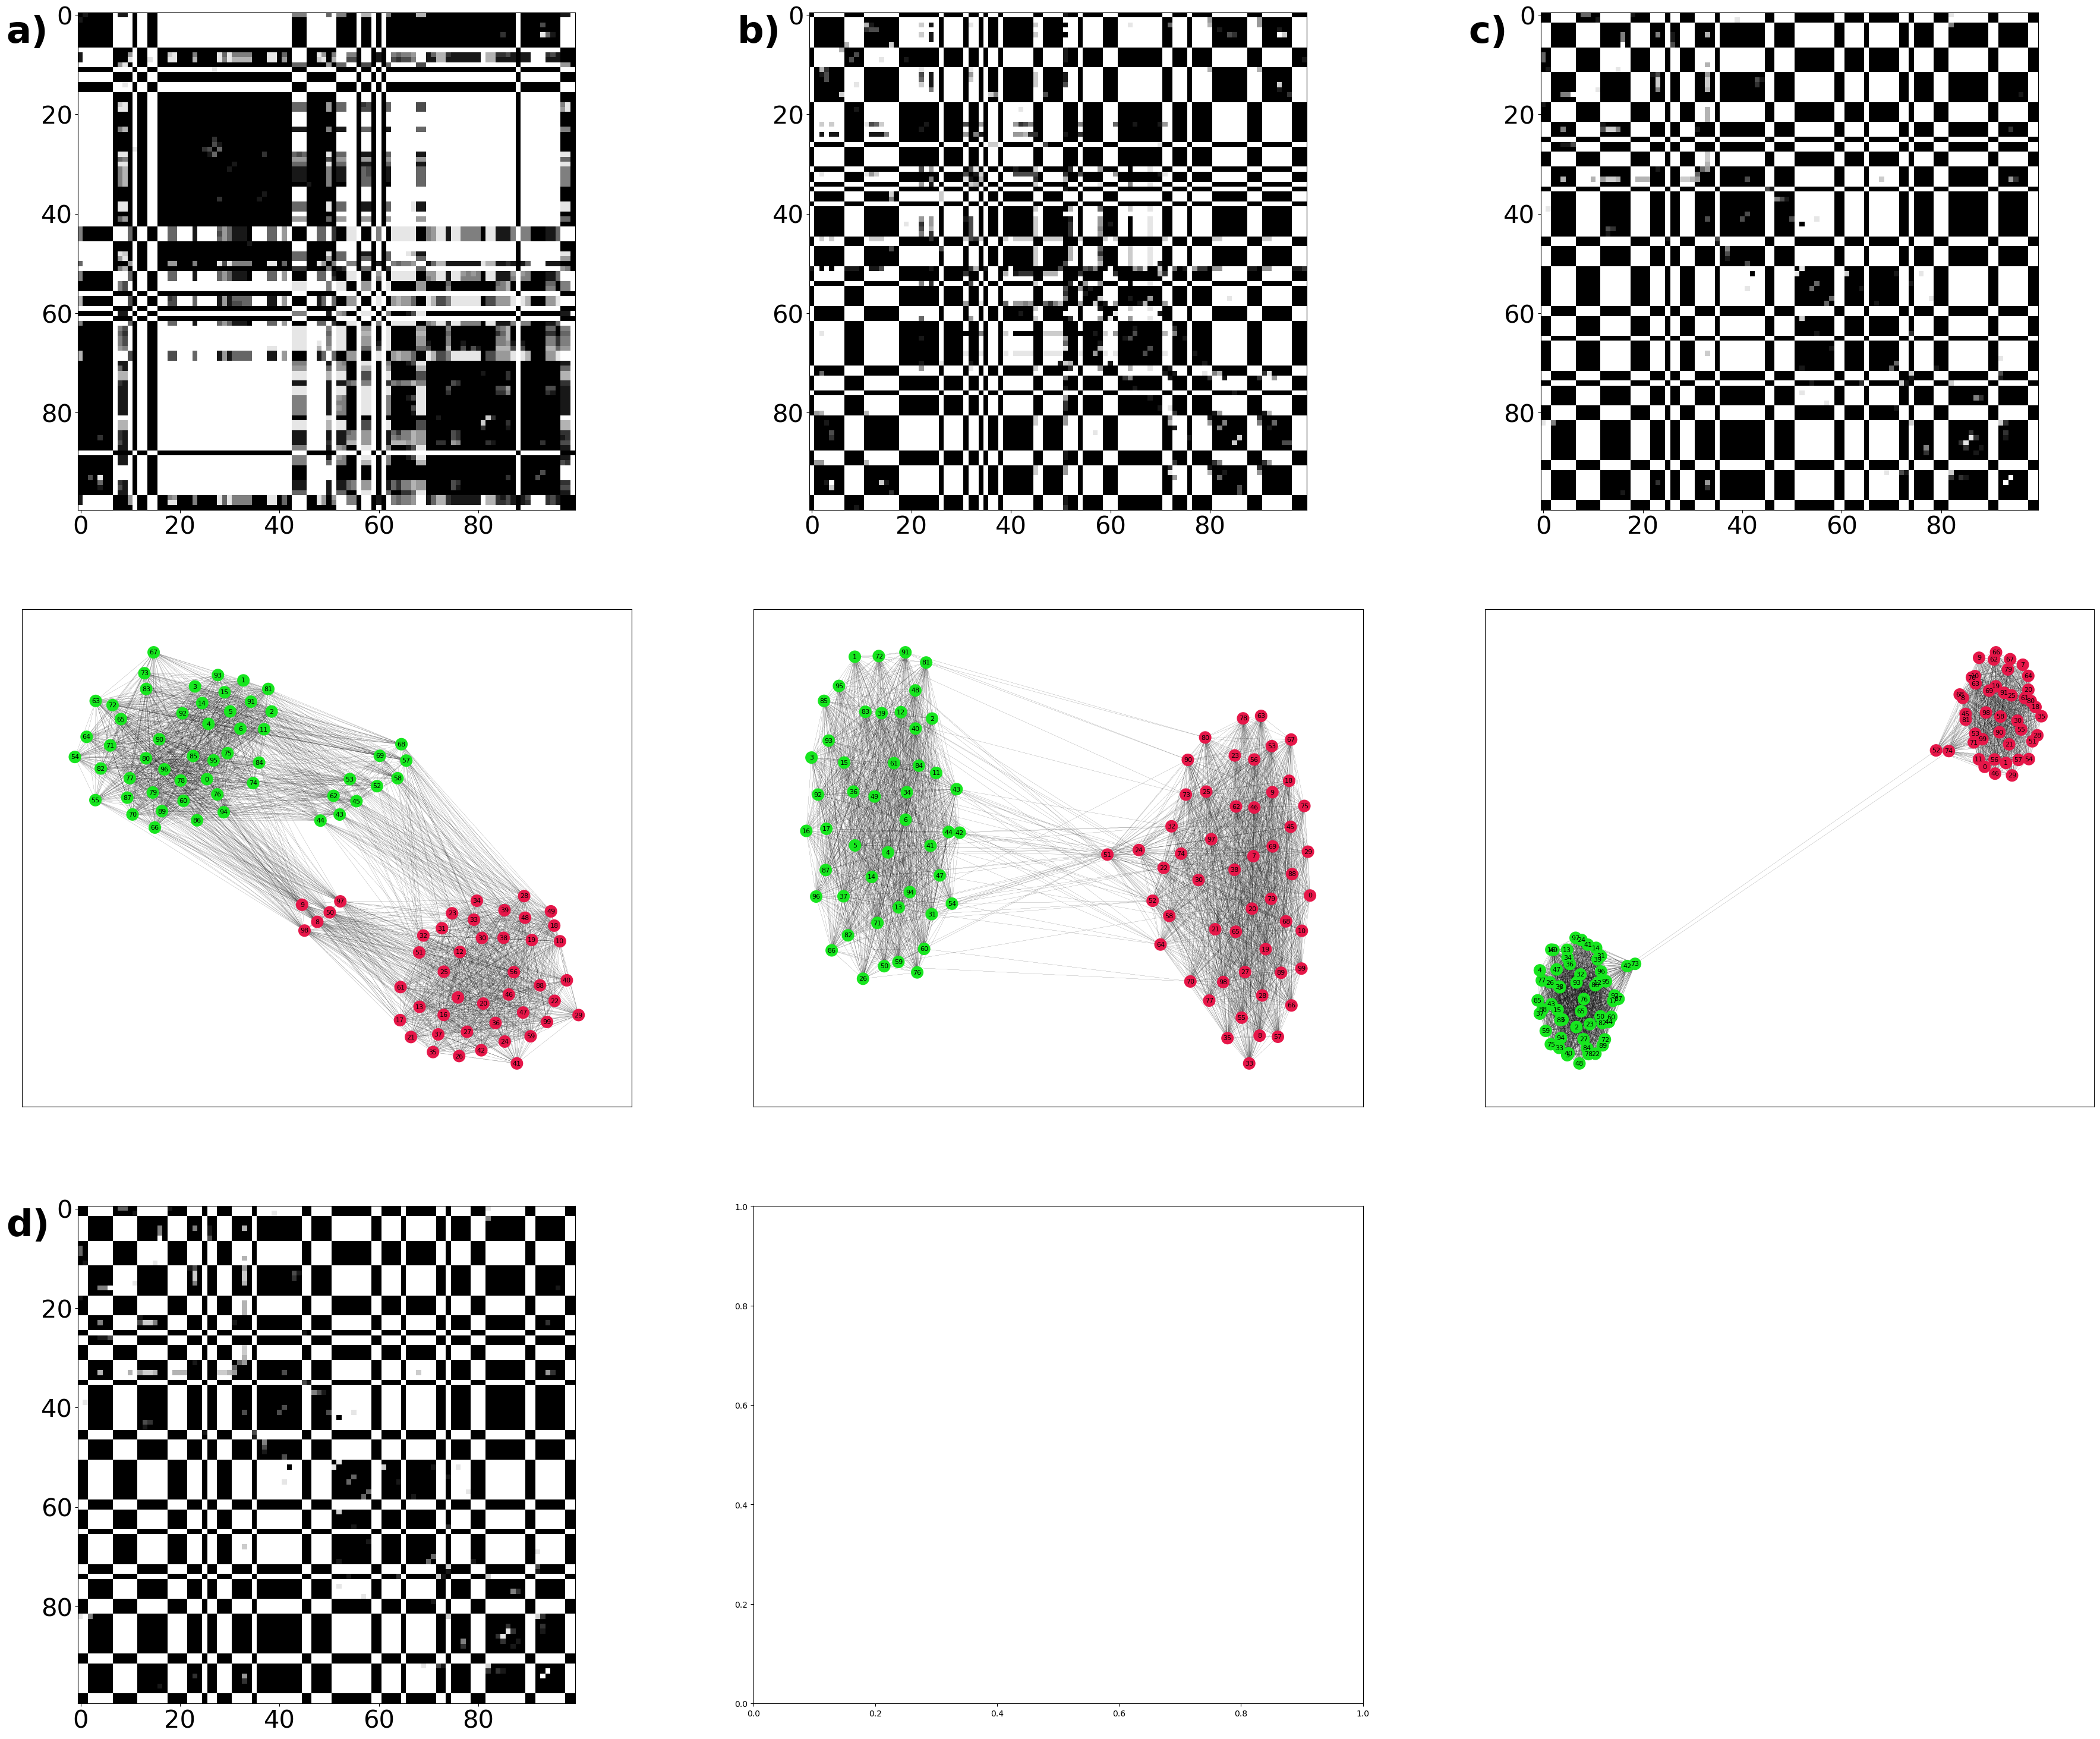

In [51]:
loyal_val_0 = []
# Extract values at specific positions from each matrix
for i in positions_to_extract:
    loyal_val_0.append(dataset_loyalty[i])
# First subplot: All edges
plt.figure(figsize=(45, 50))
plt.subplot(4, 3, 1)  # 1 row, 2 columns, first subplot
plt.imshow(loyal_val_0[0], cmap='gray_r', interpolation='none')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.text(-15, 5.5, 'a)', fontsize=45, fontweight='bold')

plt.subplot(4, 3, 2)  # 1 row, 2 columns, first subplot
plt.imshow(loyal_val_0[1], cmap='gray_r', interpolation='none')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.text(-15, 5.5, 'b)', fontsize=45, fontweight='bold')

plt.subplot(4, 3, 3)  # 1 row, 2 columns, first subplot
plt.imshow(loyal_val_0[2], cmap='gray_r', interpolation='none')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.text(-15, 5.5, 'c)', fontsize=45, fontweight='bold')

test_mtx = loyal_val_0[0]
G = nx.Graph()
G.add_nodes_from(range(len(test_mtx)))
for i in range(len(test_mtx)):
    for j in range(len(test_mtx)):
        if i != j and test_mtx[i, j] >= 5:  # Exclude self-edges
            G.add_edge(i, j, weight=test_mtx[i, j])

partition = community.best_partition(G)
node_colors = [cluster_colors[partition[node]] for node in G.nodes()]
pos = nx.spring_layout(G, k=1.9, seed=32)
node_sizes = 200
plt.subplot(4, 3, 4)  # 1 row, 2 columns, first subplot
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=0.1)
nx.draw_networkx_labels(G, pos, font_weight='medium', font_size=8)

#plt.title('Year 300', fontsize=40)

# Second subplot: Edges with weight >= 5
test_mtx = loyal_val_0[1]
G = nx.Graph()
G.add_nodes_from(range(len(test_mtx)))
for i in range(len(test_mtx)):
    for j in range(len(test_mtx)):
        if i != j and test_mtx[i, j] >= 5:  # Exclude self-edges
            G.add_edge(i, j, weight=test_mtx[i, j])

partition = community.best_partition(G)
node_colors = [cluster_colors[partition[node]] for node in G.nodes()]
pos = nx.spring_layout(G, k=1.9, seed=32)
node_sizes = 200
plt.subplot(4, 3, 5)  # 1 row, 2 columns, second subplot
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=0.1)
nx.draw_networkx_labels(G, pos, font_weight='medium', font_size=8)

#plt.title('Year 600', fontsize=40)

# Second subplot: Edges with weight >= 5
test_mtx = loyal_val_0[2]
G = nx.Graph()
G.add_nodes_from(range(len(test_mtx)))
for i in range(len(test_mtx)):
    for j in range(len(test_mtx)):
        if i != j and test_mtx[i, j] >= 5:  # Exclude self-edges
            G.add_edge(i, j, weight=test_mtx[i, j])

partition = community.best_partition(G)
node_colors = [cluster_colors[partition[node]] for node in G.nodes()]
pos = nx.spring_layout(G, seed=32)
node_sizes = 200
plt.subplot(4, 3, 6)  # 1 row, 2 columns, second subplot
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=0.1)
nx.draw_networkx_labels(G, pos, font_weight='medium', font_size=8)

#plt.title('Year 1000', fontsize=40)
###
plt.subplot(4, 3, 7)  # 1 row, 2 columns, first subplot
plt.imshow(loyal_val_0[2], cmap='gray_r', interpolation='none')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.text(-15, 5.5, 'd)', fontsize=45, fontweight='bold')

plt.subplot(4, 3, 8)  # 1 row, 2 columns, first subplot
plt.imshow(loyal_val_0[4], cmap='gray_r', interpolation='none')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.text(-15, 5.5, 'e)', fontsize=45, fontweight='bold')

plt.subplot(4, 3, 9)  # 1 row, 2 columns, first subplot
plt.imshow(loyal_val_0[5], cmap='gray_r', interpolation='none')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.text(-15, 5.5, 'f)', fontsize=45, fontweight='bold')

test_mtx = loyal_val_0[2]
G = nx.Graph()
G.add_nodes_from(range(len(test_mtx)))
for i in range(len(test_mtx)):
    for j in range(len(test_mtx)):
        if i != j and test_mtx[i, j] >= 5:  # Exclude self-edges
            G.add_edge(i, j, weight=test_mtx[i, j])

partition = community.best_partition(G)
node_colors = [cluster_colors[partition[node]] for node in G.nodes()]
pos = nx.spring_layout(G, k=1.9, seed=32)
node_sizes = 200
plt.subplot(4, 3, 10)  # 1 row, 2 columns, first subplot
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=0.1)
nx.draw_networkx_labels(G, pos, font_weight='medium', font_size=8)

#plt.title('Year 300', fontsize=40)

# Second subplot: Edges with weight >= 5
test_mtx = loyal_val_0[4]
G = nx.Graph()
G.add_nodes_from(range(len(test_mtx)))
for i in range(len(test_mtx)):
    for j in range(len(test_mtx)):
        if i != j and test_mtx[i, j] >= 5:  # Exclude self-edges
            G.add_edge(i, j, weight=test_mtx[i, j])

partition = community.best_partition(G)
node_colors = [cluster_colors[partition[node]] for node in G.nodes()]
pos = nx.spring_layout(G, k=1.9, seed=32)
node_sizes = 200
plt.subplot(4, 3, 11)  # 1 row, 2 columns, second subplot
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=0.1)
nx.draw_networkx_labels(G, pos, font_weight='medium', font_size=8)

#plt.title('Year 600', fontsize=40)

# Second subplot: Edges with weight >= 5
test_mtx = loyal_val_0[5]
G = nx.Graph()
G.add_nodes_from(range(len(test_mtx)))
for i in range(len(test_mtx)):
    for j in range(len(test_mtx)):
        if i != j and test_mtx[i, j] >= 5:  # Exclude self-edges
            G.add_edge(i, j, weight=test_mtx[i, j])

partition = community.best_partition(G)
node_colors = [cluster_colors[partition[node]] for node in G.nodes()]
pos = nx.spring_layout(G, seed=32)
node_sizes = 200
plt.subplot(4, 3, 12)  # 1 row, 2 columns, second subplot
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=0.1)
nx.draw_networkx_labels(G, pos, font_weight='medium', font_size=8)

#plt.title('Year 1000', fontsize=40)

plt.tight_layout()
plt.show()

## Wars Statistics for year

In [52]:
chunk_size = 33
conflict_num2 = []
civil_wars = []
non_civil = []
counter = 0
for sim_idx in range(data.shape[0]):
    columns = ['decision', 'attacker', 'target', 'loyalty']
    df = pd.DataFrame(data[sim_idx, 33 * 500 + 1:, :4], columns=columns)
    
    counts_civil = []
    counts_general = []
    counts_non = []
    
    size_len = 0
    for chunk_idx in range(0, len(df), chunk_size):
        size_len += chunk_size
        chunk = df.iloc[chunk_idx:chunk_idx + chunk_size]  # Select the chunk of 33 rows
        
        count_civ = len(chunk[(chunk['loyalty'] >= 5) & (chunk['decision'] == 1)])
        count_non = len(chunk[(chunk['loyalty'] < 5) & (chunk['decision'] == 1)])
        count_gen = len(chunk[chunk['decision'] == 1])
        counter += count_gen
        
        counts_civil.append(count_civ)
        counts_general.append(count_gen)
        counts_non.append(count_non)

    civil_wars.extend(counts_civil)
    conflict_num2.extend(counts_general)
    non_civil.extend(counts_non)

# Calculate frequencies
values_consecutive_cw, counts_consecutive_cw = np.unique(civil_wars, return_counts=True)
values_consecutive_g, counts_consecutive_g = np.unique(conflict_num2, return_counts=True)
values_consecutive_n, counts_consecutive_n = np.unique(non_civil, return_counts=True)


In [53]:
import numpy as np
from scipy.stats import mode, skew, kurtosis


# Total
total_conflict_num2 = np.sum(conflict_num2)
total_civil_wars = np.sum(civil_wars)
total_non_civil = np.sum(non_civil)

# Mean
mean_conflict_num2 = np.mean(conflict_num2)
mean_civil_wars = np.mean(civil_wars)
mean_non_civil = np.mean(non_civil)

# Median
median_conflict_num2 = np.median(conflict_num2)
median_civil_wars = np.median(civil_wars)
median_non_civil = np.median(non_civil)

# Mode
mode_conflict_num2 = mode(conflict_num2)
mode_civil_wars = mode(civil_wars)
mode_non_civil = mode(non_civil)

# Standard Deviation
std_conflict_num2 = np.std(conflict_num2)
std_civil_wars = np.std(civil_wars)
std_non_civil = np.std(non_civil)

# Skewness
skewness_conflict_num2 = skew(conflict_num2)
skewness_civil_wars = skew(civil_wars)
skewness_non_civil = skew(non_civil)

# Kurtosis
kurtosis_conflict_num2 = kurtosis(conflict_num2)
kurtosis_civil_wars = kurtosis(civil_wars)
kurtosis_non_civil = kurtosis(non_civil)

# Print the results
print("Total:", total_conflict_num2, total_civil_wars, total_non_civil)
print("Mean:", mean_conflict_num2, mean_civil_wars, mean_non_civil)
print("Median:", median_conflict_num2, median_civil_wars, median_non_civil)
print("Mode:", mode_conflict_num2, mode_civil_wars, mode_non_civil)
print("Standard Deviation:", std_conflict_num2, std_civil_wars, std_non_civil)
print("Skewness:", skewness_conflict_num2, skewness_civil_wars, skewness_non_civil)
print("Kurtosis:", kurtosis_conflict_num2, kurtosis_civil_wars, kurtosis_non_civil)


Total: 196529 168249 28280
Mean: 7.86116 6.72996 1.1312
Median: 8.0 6.0 1.0
Mode: ModeResult(mode=8, count=2915) ModeResult(mode=5, count=3032) ModeResult(mode=0, count=8947)
Standard Deviation: 3.3720681271884176 3.2496151154252098 1.2057804775331205
Skewness: 0.3529449634077764 0.4970250681210469 1.422380437932744
Kurtosis: 0.019063242689896676 0.20039955237576157 2.87352673535619


## Path lenght

In [54]:
def exponential_decay(x, alpha):
    return np.exp(-alpha * x)

In [55]:
def calculate_distance(site1, site2, L):
    x1, y1 = site1 // L, site1 % L  # Convert site numbers to (x, y) coordinates
    x2, y2 = site2 // L, site2 % L

    # Calculate distance along x-axis with periodic boundary conditions
    dx = min(abs(x1 - x2), L - abs(x1 - x2))
    
    # Calculate distance along y-axis with periodic boundary conditions
    dy = min(abs(y1 - y2), L - abs(y1 - y2))

    distance = dx + dy  # Manhattan distance with periodic boundary conditions
    return distance


In [56]:
distance_list = []

for i in range(data.shape[0]):
    columns = ['decision', 'attacker', 'target', 'loyalty', 'Tau', 'alpha', 'Wealth_def', 'Wealth_att','path_len',"change"]
    df = pd.DataFrame(data[i,33*100+1:,:10], columns=columns)
    
    # Filter rows where the decision column is equal to 1
    filtered_df = df[df['decision'] == 1]
    
    # Calculate distances between attacker and target for each row
    for index, row in filtered_df.iterrows():
        distance = calculate_distance(row['attacker'], row['target'], 10)
        distance_list.append(distance)


In [57]:
values_total_path, counts_total_path = np.unique(distance_list, return_counts=True)
pmf_total_path = counts_total_path / len(distance_list)

In [58]:
# Fit the data using curve_fit
params, covariance = curve_fit(exponential_decay, values_total_path, pmf_total_path)

# Extract the optimal value for alpha
optimal_alpha = params[0]

In [59]:
optimal_alpha

0.7020023630992823

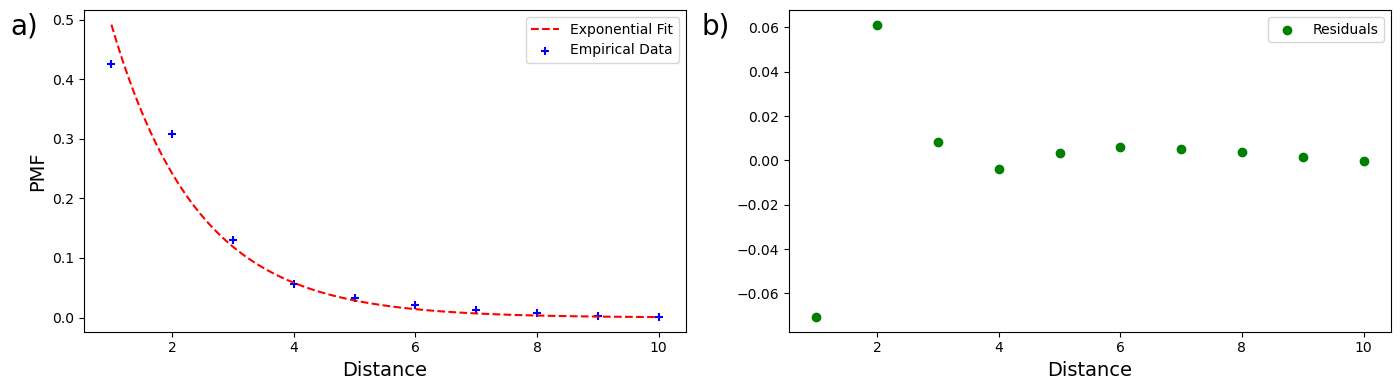

In [60]:
x = np.linspace(1, 10,100) 
# Create a single subplot with two rows (main plot and residuals)
fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

# Main Scatter plot
axs[0].plot(x, np.exp(-0.71 * x), color='red', ls = "--", label='Exponential Fit')
axs[0].scatter(values_total_path, pmf_total_path,marker='+', color='blue',  label='Empirical Data')


# Add labels and legend to the main plot
axs[0].set_ylabel('PMF', fontsize = 14)
axs[0].set_xlabel('Distance', fontsize = 14)
axs[0].text(-0.1, .95, 'a)', ha='center', va='center', transform=axs[0].transAxes, fontsize=20)
axs[0].legend()

# Residuals plot
residuals = pmf_total_path - np.exp(-0.7 * values_total_path)
axs[1].scatter(values_total_path, residuals, color='green', marker='o', label='Residuals')

# Add labels and legend to the residuals plot
axs[1].set_xlabel('Distance', fontsize = 14)
axs[1].text(1.05, .95, 'b)', ha='center', va='center', transform=axs[0].transAxes, fontsize=20)
#axs[1].set_ylabel('Residuals', fontsize = 14)
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


### Respresentation of Manhattan distance.

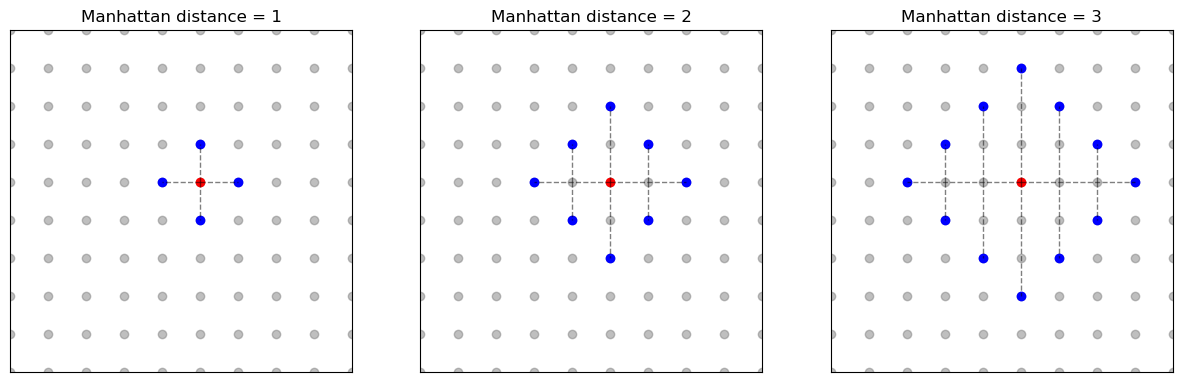

In [62]:
def von_neumann_neighbors(site, lattice_size, order=1):
    row, col = site
    indices = np.arange(-order, order + 1)
    neighbors = np.array(np.meshgrid(indices, indices)).T.reshape(-1, 2)
    neighbors = neighbors[np.abs(neighbors).sum(axis=1) == order]
    neighbors = (neighbors + site) % lattice_size
    return neighbors

def plot_neighborhoods(central_site, lattice_size, orders):
    plt.figure(figsize=(15, 5))

    for i, order in enumerate(orders, start=1):
        neighbors = von_neumann_neighbors(central_site, lattice_size, order)
        
        plt.subplot(1, len(orders), i)
        
        # Plot entire lattice in grey
        lattice_points = np.array(np.meshgrid(np.arange(lattice_size[0]), np.arange(lattice_size[1]))).T.reshape(-1, 2)
        plt.scatter(lattice_points[:, 0], lattice_points[:, 1], color='grey', marker='o', alpha=0.5, label='Lattice Points')
        
        # Plot central site and its neighbors
        plt.scatter(*central_site, color='red', label=f'Order 0 (Center)')
        plt.scatter(neighbors[:, 0], neighbors[:, 1], color='blue', label=f'Order {order} Neighbors')
        if order == 1:
            plt.plot([5, 4], [5, 5], color='black', linestyle='--', linewidth=1, alpha=0.5)
            plt.plot([5, 6], [5, 5], color='black', linestyle='--', linewidth=1, alpha=0.5)
            for neighbor in neighbors:
                plt.plot([neighbor[0], neighbor[0]], [central_site[1], neighbor[1]], color='black', linestyle='--', linewidth=1, alpha=0.5)
            
        if order == 2:
            plt.plot([5, 3], [5, 5], color='black', linestyle='--', linewidth=1, alpha=0.5)
            plt.plot([5, 7], [5, 5], color='black', linestyle='--', linewidth=1, alpha=0.5)
            for neighbor in neighbors:
                plt.plot([neighbor[0], neighbor[0]], [central_site[1], neighbor[1]], color='black', linestyle='--', linewidth=1, alpha=0.5)

        if order == 3:
            plt.plot([5, 2], [5, 5], color='black', linestyle='--', linewidth=1, alpha=0.5)
            plt.plot([5, 8], [5, 5], color='black', linestyle='--', linewidth=1, alpha=0.5)
            for neighbor in neighbors:
                plt.plot([neighbor[0], neighbor[0]], [central_site[1], neighbor[1]], color='black', linestyle='--', linewidth=1, alpha=0.5)
            
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        plt.xlim(0, lattice_size[0] - 1)
        plt.ylim(0, lattice_size[1] - 1)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title(f'Manhattan distance = {order}')

    #plt.legend()
    plt.show()

# Example Usage
lattice_size = (10, 10)
central_site = (5, 5)
orders = [1, 2, 3]

plot_neighborhoods(central_site, lattice_size, orders)
